# Introduction: 

In this research study we seek to understand and test the robustness of the Recursive Least Squares (RLS) filter algorithm. "We seek this algorithm in the application of Adaptive Cruise Control Systems (ACC). The Recursive Least Squares is an adaptive filter algorithm that recursively finds the coefficients that minimize a wighted linear least squares cost function relating to the input signals".

In terms of the application of ACC systems, we seek to model and test results from the paper called, "Online Paramter Estimation Methods for Adaptive Cruise Control Systems". We seek test additional scenarios to continue testing the robustness of the algorithmic filter. 

# Mathematical Background:

We adopt the **Constant Time Headway–Relative Velocity (CTH–RV)** car–following model:

$$
\dot v(t)
= \alpha\bigl(s(t) - \tau\,v(t)\bigr)
  + \beta\,\bigl(u(t) - v(t)\bigr)
\quad\text{(continuous‐time)}\tag{1}
$$

where  
- $s(t)$ is the space gap,  
- $v(t)$ is the ego-vehicle speed,  
- $\Delta v(t)=u(t)-v(t)$ is the relative speed to the leader,  
- $\theta=[\alpha,\beta,\tau]^\top$ are the model parameters.

Discretizing with a forward-Euler step $\Delta T$ yields:

$$
v_{k+1}
= v_k
  + \alpha\,(s_k - \tau\,v_k)\,\Delta T
  + \beta\,(u_k - v_k)\,\Delta T
\tag{5}
$$

Rewriting in linear-regression form:

$$
v_{k+1}
= \gamma_1\,v_k + \gamma_2\,s_k + \gamma_3\,u_k,
\quad
\begin{aligned}
\gamma_1 &= 1 - (\alpha\,\tau + \beta)\,\Delta T,\\
\gamma_2 &= \alpha\,\Delta T,\\
\gamma_3 &= \beta\,\Delta T.
\end{aligned}
\tag{6}
$$

Stacking data for $k=1,\dots,K-1$:

$$
Y = X\,\gamma,
\quad
Y = 
\begin{bmatrix}
v_2\\
\vdots\\
v_K
\end{bmatrix},
\quad
X =
\begin{bmatrix}
v_1 & s_1 & u_1\\
\vdots & \vdots & \vdots\\
v_{K-1} & s_{K-1} & u_{K-1}
\end{bmatrix}
\tag{8}
$$

The **RLS** algorithm then updates $\gamma$ sequentially as each $X_k,Y_k$ arrives:

$$
\begin{aligned}
K_k &= \frac{P_{k-1}\,X_k}{1 + X_k^\top P_{k-1} X_k},\\
\gamma_k &= \gamma_{k-1} + K_k\bigl(Y_k - X_k^\top\gamma_{k-1}\bigr),\\
P_k &= \bigl(I - K_k\,X_k^\top\bigr)\,P_{k-1},
\end{aligned}
\tag{9}
$$

with initial guess $\gamma_{0}$ and covariance $\boldsymbol{P}_0$.

# Scenarios: 

We seek to understand the computational flexibility, and rigor of RLS under 4 realistic scenarios. 

### Case 1: Default Case
In this first case we seek to simulate two vehicles, $\vec{u}(t) \in \mathbb{R}^n$ which is the lead vehicle and the ego vehicle, $\vec{v}(t) \in \mathbb{R}^n$. We model these two cars, with $u(t)$ in the lead on a highway. We will test two subcases for this default case:
- RLS under Equillibrium $\implies$ constant predetermined speed. 
- RLS under Non-equillobrium $\implies$ non-constant speeds (with added fluxuations in speeds).

### Case 2: Road Curve Case
In this second case we seek to simulate our same two vehicles $\vec{u}(t)$ and $\vec{v}(t)$; however, what would change in this scenario is that we have these two vehicles driving from the highway right into a steep curve. We seek to test the robustness of RLS under this aggresive scenario.

There is an exception when it comes to the states we seek to model. Sice we are unable to simulate these two vehicles going at a constant speed $\implies$ that the cars would fall off the curved road and head into a collision. Therefore, for this case, we will only be simulating a non-equillibrium scenario. 
- RLS under non-equillibrium $\implies$ non constant speeds (with added fluxuations and drops in speeds to simulate curve).

### Case 3: Suburbs Case
In this second case we seek to simulate our same two vehicles $\vec{u}(t)$ and $\vec{v}(t)$; however, what would change in this scenario is that we will be testing the robustness of RLS in the suburbs of a city. This scenario will seek to test how reliable RLS is in a suburban environment. With this case, several road hazards will be implemented in the form of: speed bumps, pedestrians, yield signs, etc.
- RLS under Equillibrium $\implies$ constant predetermined speed with road hazards. 
- RLS under non-equillobrium $\implies$ non-constant speeds (with added fluxuations in speeds) with road hazards.

### Case 4: Aggresive Lead
In this fourth and final scenario that we want to simulate, we will still have our too vehicles, $\vec{u}(t)$ and $\vec{v}(t)$; however, what would change in this scenario is that we will have these two vehicles who will be driving on a highway. However, what we will be testing is the RLS capacity to recover the $\alpha$, $\beta$, and $\tau$ parameters with an aggresive lead vehicle.
- RLS under non-equillobrium $\implies$ non-constant speeds (with added fluxuations in speeds) with road hazards.

# Beginning of Script: 

In [ ]:
# Needed Dependencies: 
import numpy as np
import matplotlib.pyplot as plt

# Invert Gamma Function:  
def invert_gamma(gamma, dt):
    """
    Given gamma1, gamma2, gamma3 = alpha, beta, tau, we are able to directly
    solve for alpha, beta, tau by using the following equations algebraically:
    - alpha = gamma2 / dt
    - beta = gamma3 / dt
    - tau = ((1 - gamma1 - gamma3) / gamma2)
    """
    gamma1, gamma2, gamma3 = gamma

    alpha = gamma2/dt
    beta  = gamma3/dt

    if abs(alpha) < 1e-8: # Added tolerance for numerical stability
        tau = 0.0
    else:
        tau = ((1 - gamma1 - gamma3) / gamma2)
    return alpha, beta, tau

# RLS Filter Function: 
def rls_filter(final_v_t, final_u_t, final_s_t, time, dt):
    gamma_est = np.array([0.9, 0.01, 0.01])  # some initial guess
    true_theta = np.array([0.08, 0.12, 1.5]) # true theta vector

    u_t = final_u_t
    v_t = final_v_t
    s_t = final_s_t
    
    P = np.eye(3)*1000.0 # covariance matrix 

    gamma_history = np.zeros((time, 3))
    theta_history = np.zeros((time, 3))  # [alpha, beta, tau] at each step - 3 x 900 matrix storing all values of theta

    # Initialize:
    gamma_history[0] = gamma_est
    theta_history[0] = invert_gamma(gamma_est, dt)

    # RLS Algorithm:
    for k in range(1, time):
        Y = v_t[k]
        X = np.array([v_t[k-1], s_t[k-1], u_t[k-1]])

        # Compute Kalman gain
        denominator = 1.0 + X.T.dot(P).dot(X)
        K = P.dot(X) / denominator

        # RLS update for gamma parameters
        gamma_est = gamma_est + K*(Y - X.T.dot(gamma_est))
        P = (np.eye(3) - np.outer(K, X)).dot(P)

        # Store history of parameter estimates
        gamma_history[k] = gamma_est
        theta_history[k] = invert_gamma(gamma_est, dt)

    alpha_est_final, beta_est_final, tau_est_final = theta_history[-1]
    print("Final estimated alpha = %.3f (true=%.3f)" % (alpha_est_final, true_theta[0]))
    print("Final estimated beta  = %.3f (true=%.3f)"  % (beta_est_final, true_theta[1]))
    print("Final estimated tau   = %.3f (true=%.3f)"   % (tau_est_final, true_theta[2]))
    print("-------------------------")
    print(f"Alpha Error: {true_theta[0] - alpha_est_final:.3f}")
    print(f"Beta Error: {true_theta[1] - beta_est_final:.3f}")
    print(f"Tau Error: {true_theta[2] - tau_est_final:.3f}")

    # Plot - Alpha, Beta, Tau Convergence
    t_axis = np.arange(time)
    fig, axes = plt.subplots(3,1, figsize=(12,10), sharex=True)

    params  = ["alpha", "beta", "tau"]
    trueval = [true_theta[0], true_theta[1], true_theta[2]]
    colors  = ["r", "g", "b"]

    for i, ax in enumerate(axes):
        ax.plot(t_axis, theta_history[:, i], label=f"Estimated {params[i]}", color=colors[i])
        ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=f"True {params[i]}")
        ax.legend()
        ax.grid()

    axes[-1].set_xlabel("Time step (k)")
    plt.suptitle("RLS Parameter Convergence")
    plt.show()
    plt.close()




time = 900 # total number of samples
t_axis = np.arange(time)

dt = 1e-1 # time step

np.random.seed(0) # for reproducibility

true_theta = np.array([0.08, 0.12, 1.5]) # true theta vector

### Conditions of Initialization: 

In [11]:
s_0 = 60.0 # initial space gap (60 meters)
u_0 = 33.0 # initial lead velocity (33 m/s)
v_0 = 31.0 # initial following velocity (31 m/s)

dv_max = 3.0 # maximum acceleration/deceleration (3 m/s^2)

### Case 1: Default Case

Final estimated alpha = -0.044 (true=0.080)
Final estimated beta  = 0.087 (true=0.120)
Final estimated tau   = 1.409 (true=1.500)
-------------------------
Alpha Error: 0.124
Beta Error: 0.033
Tau Error: 0.091


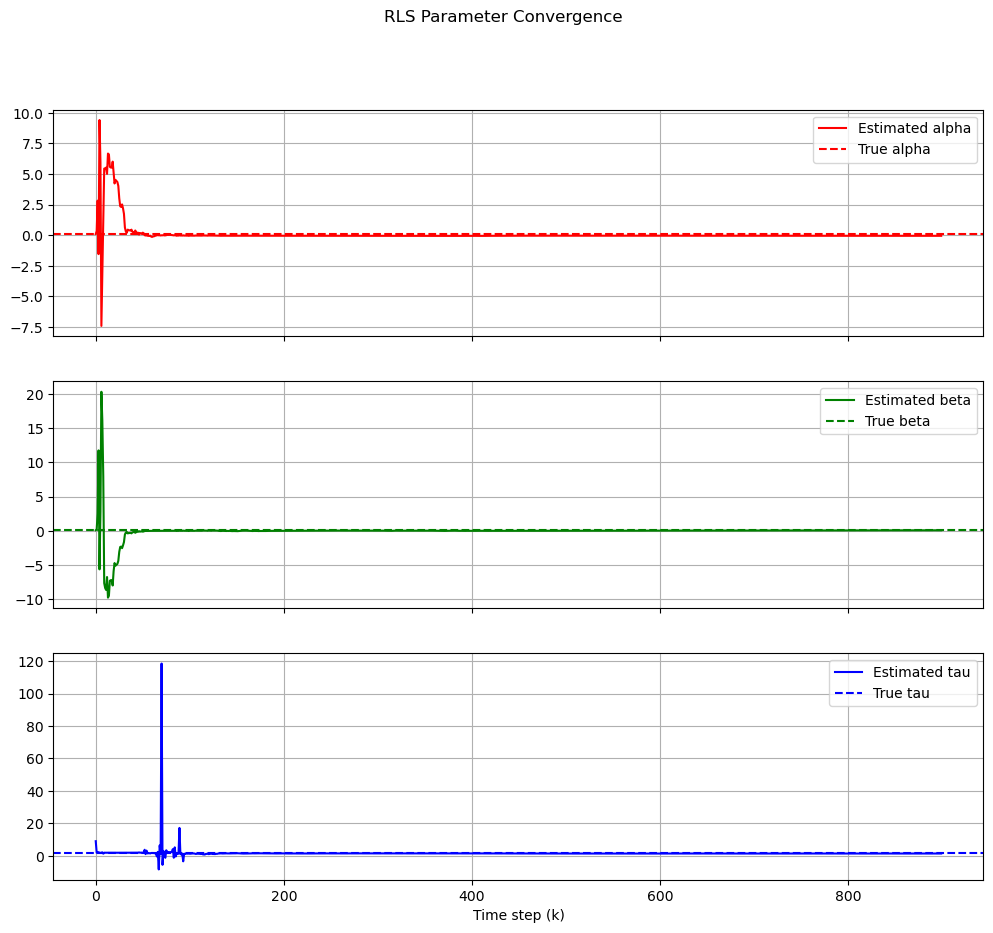

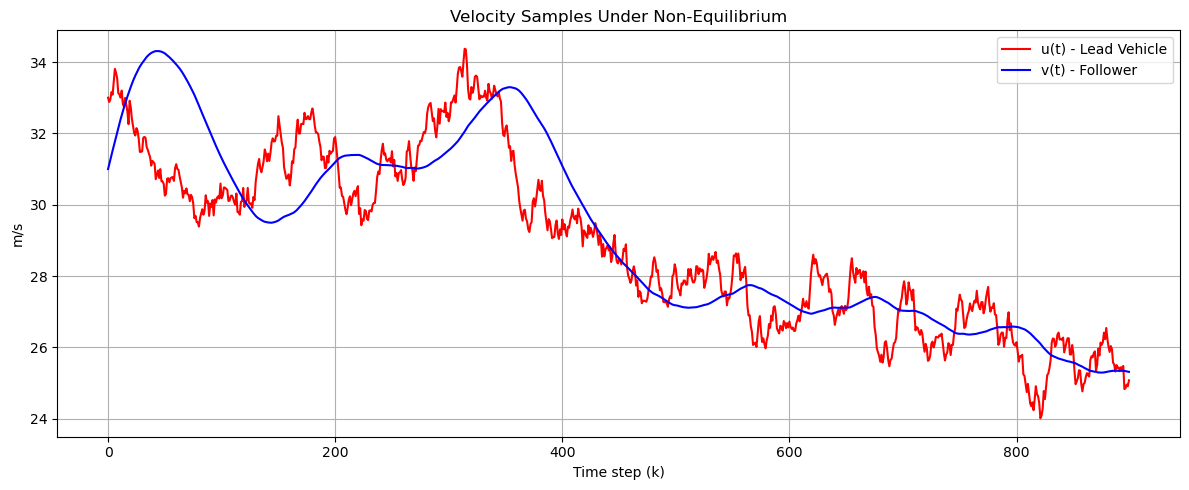

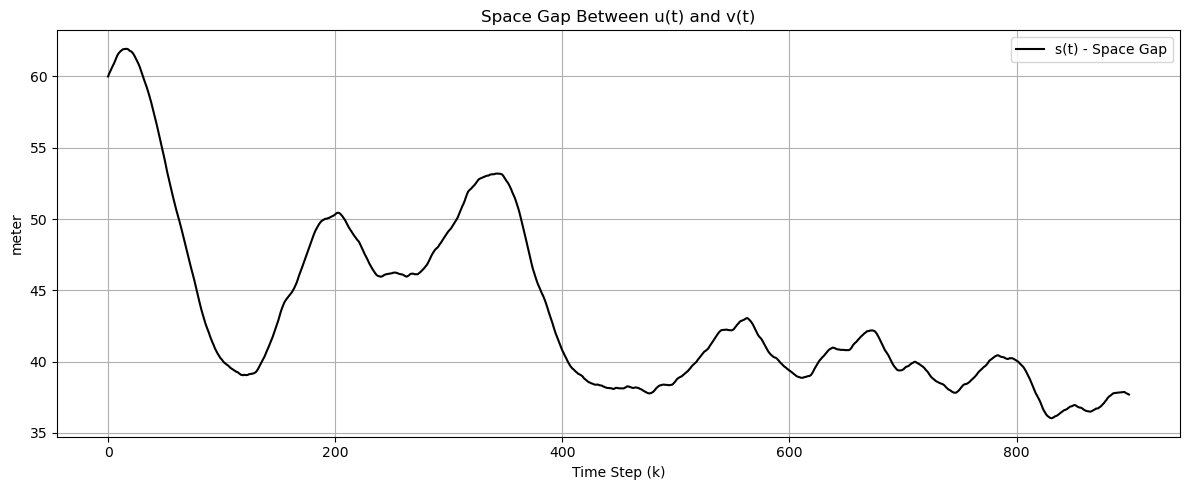

Final estimated alpha = 0.020 (true=0.080)
Final estimated beta  = 0.195 (true=0.120)
Final estimated tau   = 1.507 (true=1.500)
-------------------------
Alpha Error: 0.060
Beta Error: -0.075
Tau Error: -0.007


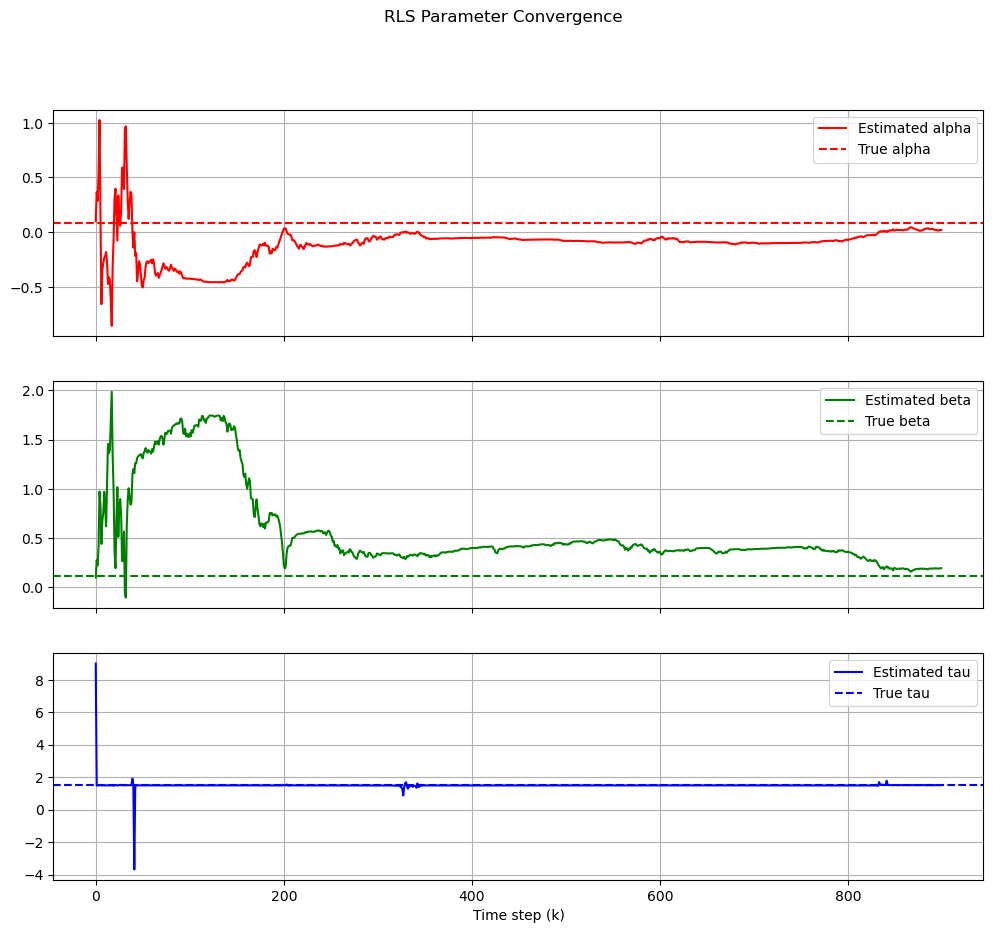

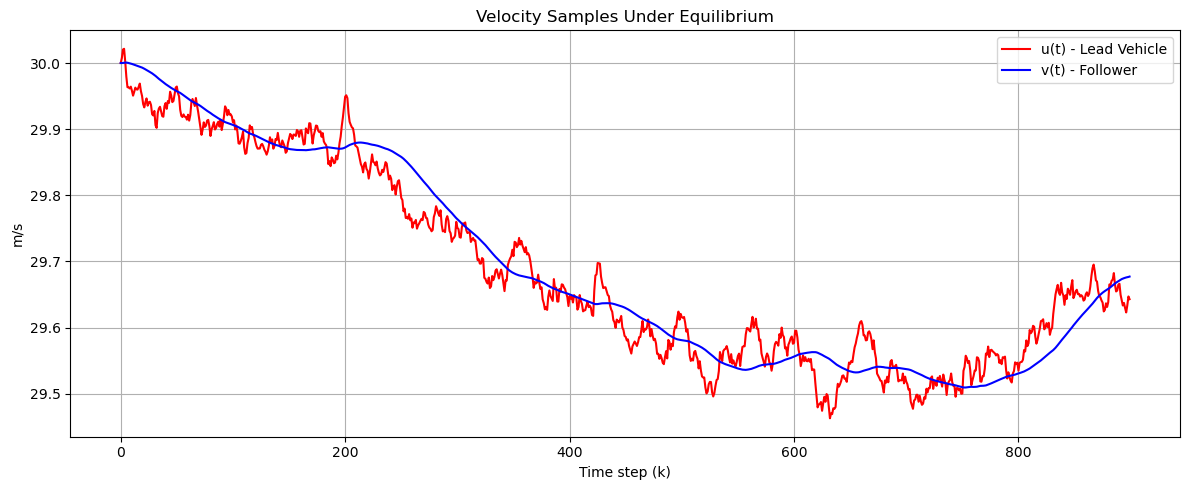

In [14]:
def scenario_1_data (scenario):
    if scenario == "NON-EQ":
        # Allocate Arrays for u_t, v_t, and s_t:
        u_t = np.zeros(time)
        v_t = np.zeros(time)
        s_t = np.zeros(time)

        u_t[0] = u_0
        v_t[0] = v_0
        s_t[0] = s_0

        """
        Note: This section generates samples for the non-equillibrium case. 
        """
        for i in range(1, time):
            u_t[i] = u_t[i - 1] + np.random.normal(loc=0, scale=0.25) # mean 0, variance 0.5

            # Compute Current Gap and Velocity: 
            s_prev = s_t[i - 1]
            v_prev = v_t[i - 1]
            u_prev = u_t[i - 1]

            # CTH-RV Update (Following Vehicle):
            acc = true_theta[0] * (s_prev - true_theta[2] * v_prev) + true_theta[1] * (u_prev - v_prev) 
            acc = np.clip(acc, -dv_max, dv_max)  # apply physical constraint

            # Update Follower Velocity and Space Gap
            v_t[i] = v_prev + acc * dt
            s_t[i] = s_prev + (u_prev - v_prev) * dt 

        final_u_t = u_t
        final_v_t = v_t
        final_s_t = s_t

        #final_data = [u_t, v_t, s_t]
        rls_filter(final_u_t, final_v_t, final_s_t, time, dt)
        
        # Plot Velocities:
        plt.figure(figsize=(12, 5))
        plt.plot(u_t, label="u(t) - Lead Vehicle", color="red")
        plt.plot(v_t, label="v(t) - Follower", color="blue")
        plt.title("Velocity Samples Under Non-Equilibrium")
        plt.xlabel("Time step (k)")
        plt.ylabel("m/s")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot Space Gap: 
        plt.figure(figsize=(12, 5))
        plt.plot(s_t, label="s(t) - Space Gap", color="black")
        plt.title("Space Gap Between u(t) and v(t)")
        plt.xlabel("Time Step (k)")
        plt.ylabel("meter")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    elif scenario == "EQ":
        # Allocate Arrays for u_t, v_t, and s_t:
        u_t = np.zeros(time)
        v_t = np.zeros(time)
        s_t = np.zeros(time)

        # Set initial conditions for equilibrium
        equilibrium_speed = 30.0
        u_t[0] = equilibrium_speed
        v_t[0] = equilibrium_speed
        s_t[0] = true_theta[2] * equilibrium_speed  # s = τv

        # Generate equilibrium samples
        for i in range(1, time):
            u_t[i] = u_t[i - 1] + np.random.normal(0, 0.01)  # small noise for realism

            s_prev = s_t[i - 1]
            v_prev = v_t[i - 1]
            u_prev = u_t[i - 1]

            acc = true_theta[0] * (s_prev - true_theta[2] * v_prev) + true_theta[1] * (u_prev - v_prev)
            acc = np.clip(acc, -dv_max, dv_max)

            v_t[i] = v_prev + acc * dt
            s_t[i] = s_prev + (u_prev - v_prev) * dt

        final_u_t = u_t
        final_v_t = v_t
        final_s_t = s_t

        #final_data = [u_t, v_t, s_t]
        rls_filter(final_u_t, final_v_t, final_s_t, time, dt)
        
        # Plot velocities
        plt.figure(figsize=(12, 5))
        plt.plot(u_t, label="u(t) - Lead Vehicle", color="red")
        plt.plot(v_t, label="v(t) - Follower", color="blue")
        plt.title("Velocity Samples Under Equilibrium")
        plt.xlabel("Time step (k)")
        plt.ylabel("m/s")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else: None

scenario_1_data("NON-EQ")
scenario_1_data("EQ")


        
